<h2>Annuiteettilainan lyhennystaulukko ja sen havainnollistaminen</h2>

Olen saanut tähän ideat artikkelista http://pbpython.com/amortization-model-revised.html.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import date
from dateutil.relativedelta import *

%matplotlib inline
plt.style.use('seaborn-whitegrid')

Generoidaan lainan lyhennykset generator-tyyppistä funktiota käyttäen. Generator-tyyppinen funktio toimii tässä nopeammin ja muistia säästävämmin kuin muut ratkaisut. Lisätietona generator-funktioista https://www.learnpython.org/en/Generators 

Generator palauttaa lyhennykset OrderedDict-oliona (katso lisätietoa https://docs.python.org/2/library/collections.html#collections.OrderedDict). 

Generoidut lyhennykset on helppo lukea pandas dataframeen jatkoanalyysejä varten.

In [2]:
def lyhennys(laina, korkokanta, aika_vuosina, maksuerä, ylim_maksu, aloitus_päivä, maksueriä_vuodessa):
# ylim_maksu: Ylimääräinen lyhennys, joka tehdään jokaisen maksuerän yhteydessä.

    p = 1 #periodi
    ennen_lyhennystä = laina #laina ennen maksuerää
    lyhennyksen_jälkeen = laina #laina maksuerän jälkeen
    
    while lyhennyksen_jälkeen > 0:
        
        korko = round(((korkokanta/maksueriä_vuodessa) * ennen_lyhennystä), 2)
        
        maksuerä = min(maksuerä, ennen_lyhennystä + korko)
        
        laina = maksuerä - korko #tämän verran lainaa lyhennetään
        
        ylim_maksu = min(ylim_maksu, ennen_lyhennystä - laina)
        lyhennyksen_jälkeen = ennen_lyhennystä - (laina + ylim_maksu)

        yield OrderedDict([('Kuukausi',aloitus_päivä),
                           ('Jakso', p),
                           ('Laina ennen lyhennystä', ennen_lyhennystä),
                           ('Maksuerä', maksuerä),
                           ('Lyhennys', laina),
                           ('Korko', korko),
                           ('Ylimääräinen lyhennys', ylim_maksu),
                           ('Laina lyhennyksen jälkeen', lyhennyksen_jälkeen)])
        
        p += 1
        aloitus_päivä += relativedelta(months=1) #sama päivä seuraavassa kuussa
        ennen_lyhennystä = lyhennyksen_jälkeen

lyhennys_taulukko-funktio kutsuu lyhennys-funktiota, sijoittaa tulokset dataframeen ja laskee lainaan liittyviä tilastotietoja.

In [3]:
def lyhennys_taulukko(laina, korkokanta, aika_vuosina,
                       ylim_maksu=0, maksueriä_vuodessa=12, aloitus_päivä=date.today()):
       
    maksuerä = -round(np.pmt(korkokanta/maksueriä_vuodessa, aika_vuosina*maksueriä_vuodessa, laina), 2)
    
    # lyhennys-funktion tulokset dataframeen
    taulukko = pd.DataFrame(lyhennys(laina, korkokanta, aika_vuosina, maksuerä,
                                     ylim_maksu, aloitus_päivä, maksueriä_vuodessa))
    # Sarakkeet haluttuun järjestykseen
    taulukko = taulukko[["Jakso", "Kuukausi", "Laina ennen lyhennystä", "Maksuerä", "Korko", 
                         "Lyhennys", "Ylimääräinen lyhennys", "Laina lyhennyksen jälkeen"]]
    
    # Varmistetaan, että Python tunnistaa päivämäärät päivämääriksi
    taulukko["Kuukausi"] = pd.to_datetime(taulukko["Kuukausi"])
    
    #Tilastotietoja
    loppu_päivä = taulukko["Kuukausi"].iloc[-1]
    tiedot = pd.Series([loppu_päivä, taulukko["Jakso"].count(), korkokanta,
                       aika_vuosina, laina, maksuerä, ylim_maksu,
                       taulukko["Korko"].sum()],
                       index=["Loppupäivä", "Maksujen lukumäärä", "Korkokanta", "Aika vuosina", "Lainan suuruus",
                             "Maksuerä", "Ylimääräinen lyhennys", "Korot yhteensä"])
    
    return taulukko, tiedot

In [4]:
# Näin lyhennys_taulukko -funktiota kutsutaan
taulukko, tiedot = lyhennys_taulukko(100000, .04, 20, aloitus_päivä=date(2019,6,10))

In [5]:
# Näin nähdään lyhennys_taulukko -funktion laskemat tilastotiedot
tiedot

Loppupäivä               2039-05-10 00:00:00
Maksujen lukumäärä                       240
Korkokanta                              0.04
Aika vuosina                              20
Lainan suuruus                        100000
Maksuerä                              605.98
Ylimääräinen lyhennys                      0
Korot yhteensä                       45435.2
dtype: object

In [6]:
# Näin nähdään tiettyyn periodiin liittyvät maksutiedot
taulukko.iloc[5]

Jakso                                          6
Kuukausi                     2019-11-10 00:00:00
Laina ennen lyhennystä                   98627.6
Maksuerä                                  605.98
Korko                                     328.76
Lyhennys                                  277.22
Ylimääräinen lyhennys                          0
Laina lyhennyksen jälkeen                98350.4
Name: 5, dtype: object

In [7]:
# Vaihtoehtolaskelmia on helppo tehdä lyhennys_taulukko-funktiolla
taulukko1, tiedot1 = lyhennys_taulukko(100000, .04, 20, ylim_maksu=50, aloitus_päivä=date(2019,6,10))
taulukko2, tiedot2 = lyhennys_taulukko(100000, .05, 20, ylim_maksu=200, aloitus_päivä=date(2019,6,10))
taulukko3, tiedot3 = lyhennys_taulukko(100000, .04, 15, ylim_maksu=0, aloitus_päivä=date(2019,6,10))

In [8]:
# Vaihtoehtolaskelmien tilastotiedot taulukkona
pd.DataFrame([tiedot1, tiedot2, tiedot3])

,Loppupäivä,Maksujen lukumäärä,Korkokanta,Aika vuosina,Lainan suuruus,Maksuerä,Ylimääräinen lyhennys,Korot yhteensä
0,2037-03-10,214,0.04,20,100000,605.98,50,39872.43
1,2032-09-10,160,0.05,20,100000,659.96,200,37050.60
2,2034-05-10,180,0.04,15,100000,739.69,0,33143.79


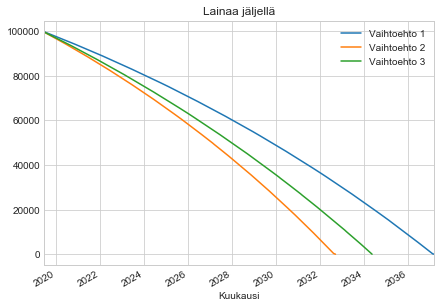

In [9]:
# Jäljellä olevan lainan havainnollistaminen
fig, ax = plt.subplots(1, 1, figsize=(7,5))
taulukko1.plot(x='Kuukausi', y='Laina lyhennyksen jälkeen', label="Vaihtoehto 1", ax=ax)
taulukko2.plot(x='Kuukausi', y='Laina lyhennyksen jälkeen', label="Vaihtoehto 2", ax=ax)
taulukko3.plot(x='Kuukausi', y='Laina lyhennyksen jälkeen', label="Vaihtoehto 3", ax=ax)
ax.set_title("Lainaa jäljellä");

In [10]:
# Muodostetaan dataframe y koroista

def muodosta_data(taulukko, tiedot):
    y = taulukko.set_index('Kuukausi')['Korko'].resample("A").sum().reset_index()
    y["Vuosi"] = y["Kuukausi"].dt.year
    y.set_index('Vuosi', inplace=True)
    y.drop('Kuukausi', 1, inplace=True)
    otsikko="{} vuotta, korkokanta {} % , lisälyhennys  {} €".format(tiedot['Aika vuosina'], 
                                tiedot['Korkokanta']*100, tiedot['Ylimääräinen lyhennys'])
    return y, otsikko
    
y1, otsikko1 = muodosta_data(taulukko1, tiedot1)
y2, otsikko2 = muodosta_data(taulukko2, tiedot2)
y3, otsikko3 = muodosta_data(taulukko3, tiedot3)

y = pd.concat([y1, y2, y3], axis=1)

Text(0.5, 1.0, 'Maksetut korot')

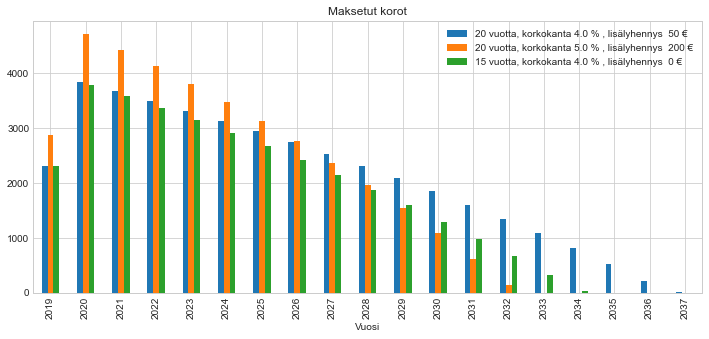

In [11]:
# Korkojen havainnollistaminen
fig, ax = plt.subplots(1, 1, figsize=(12,5))
y.plot.bar(ax=ax)
ax.legend([otsikko1, otsikko2, otsikko3])
ax.set_title("Maksetut korot")

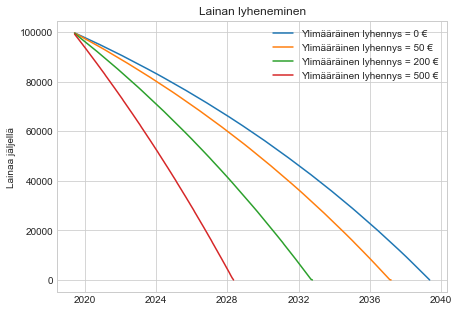

In [13]:
ylim_maksut = [0, 50, 200, 500]
fig, ax = plt.subplots(1, 1, figsize=(7,5))

for maksu in ylim_maksut:
    result, _ = lyhennys_taulukko(100000, .04, 20, ylim_maksu=maksu, aloitus_päivä=date(2019,6,10))
    ax.plot(result['Kuukausi'], result['Laina lyhennyksen jälkeen'], 
            label='Ylimääräinen lyhennys = {} €'.format(str(maksu)))
ax.set_title("Lainan lyheneminen")
ax.set_ylabel("Lainaa jäljellä")
ax.legend()